In [ ]:
''' To run this notebook you need the following package versions'''

numpy       1.23.5
keras       2.12.0
tensorflow  2.12.0
sklearn     1.2.2

In [ ]:
''' Warning PGRNN optimization takes 1 to several days to finish'''

### Necessary packages

In [1]:
# Common imports
import glob
import random
import os
import re
import absl.logging
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
import tensorflow_probability as tfp
from skopt import gp_minimize
from skopt.callbacks import DeltaYStopper
from keras import backend as K 

absl.logging.set_verbosity(absl.logging.ERROR)# Avoid print error

from datetime import datetime
import numpy as np 
from numpy.random import seed
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.mode.chained_assignment = None # avoid error 
pd.options.display.float_format = '{:.5f}'.format # No scientific annotation when print dataframe
from functools import reduce
  
# ADA and Modeling imports
import math
import sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error, accuracy_score
from IPython.display import clear_output
import statistics
from scipy.stats import stats
import tensorflow as tf
from tensorflow import keras
#from tsmoothie.smoother import *

# To plot pretty figures
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Build function
#from HelperFunctions import *
#from Implementation import *

# To generate an stable output across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# MAchine learing packages 
import tensorflow 
from keras.layers import SimpleRNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import MeanMetricWrapper
from tensorflow.keras import layers
from tensorflow.keras import metrics 
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adamax, Nadam
from tensorflow.keras.activations import selu,elu,relu,tanh
from tensorflow.keras.initializers import RandomNormal
from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping
import time

from keras import Input #
from keras.models import Sequential, load_model
import keras.backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, LSTM, GRU, InputLayer, Flatten, Conv1D, Activation, LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)

n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 16


### PGRNN model

#### Functions: Model, Loss and metric

In [2]:
''' Loss and Metric functions'''
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())
def Ldeltas(y_true, y_pred):
    y_true_diffs = tf.experimental.numpy.abs(tf.experimental.numpy.diff(y_true, axis=0))
    p_80 = tfp.stats.percentile(y_true_diffs, 80)
    y_pred_diffs = tf.experimental.numpy.abs(tf.experimental.numpy.diff(y_pred, axis=0))
    delta = tf.reduce_sum(tf.nn.relu(y_pred_diffs - p_80))
    return delta / tf.cast(tf.shape(y_true)[0], tf.keras.backend.floatx())
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

def Lstft(y_true, y_pred):
    s_pred = tf.abs(tf.signal.rfft(y_pred))
    s_true = tf.abs(tf.signal.rfft(y_true))
    stft = tf.reduce_sum(tf.abs(s_pred - s_true))
    return stft / (tf.cast(tf.shape(y_true)[0], tf.keras.backend.floatx()) // 2 + 1)

def combined_loss(l1,l2):
    def loss(y_true, y_pred):
        lambda1 = l1 # choose a value for lambda1
        lambda2 = l2 # choose a value for lambda2
        rmse = K.sqrt(K.mean(K.square(y_pred - y_true)))
        ldeltas = Ldeltas(y_true, y_pred)
        lstft = Lstft(y_true, y_pred)
        return rmse + lambda1 * ldeltas + lambda2 * lstft
    return loss

def combined_metric(l1m,l2m):
    def metric(y_true, y_pred):
        # Compute the validation loss
        ss_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
        ss_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
        r2 = 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())


        loss = tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred))

        # Combine the loss and R^2 score
        combined = loss*l1m + abs(1 - r2)*l2m
        return combined

    return metric

In [15]:
''' Funcitons to get one ensamble PGRNN from it CV optimization'''

def concatenate_data(X_train, y_train, X_test, y_test):
    X = np.concatenate([X_train, X_test], axis=0)
    y = np.concatenate([y_train, y_test], axis=0)
    return X, y
def Unreshape_df(Xs, ys=None):
    X = np.concatenate(Xs, axis=0)
    if ys is not None:
        y = np.concatenate(ys, axis=0)
        return X, y
    else:
        return X

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
        # return np.sqrt(np.mean(np.square(y_pred - y_true)))  
def calculate_weighted_average(predictions, weights):
    return sum([weight*preds for preds, weight in zip(predictions, weights)])

def evaluate_ensemble(predictions, weights, y_true):
    pred = calculate_weighted_average(predictions, weights)
    loss = rmse(y_true,pred)
    return r2_score(y_true, pred),loss

def Ensemble(X_topredict,best_weights,best_models):
    model_predictions = []
    for model in best_models:
        y_pred = model.predict(X_topredict).T[0]
        model_predictions.append(y_pred+abs(np.min(y_pred)))

    # Combine the model predictions using the optimized weights to obtain the final prediction
    final_prediction = calculate_weighted_average(model_predictions, best_weights)
    return final_prediction

In [5]:
''' architechture PGRNN optimization at each fold '''
search_space = [Categorical([60,120], name='batch_size'),
                Categorical([20,60], name='epochs'),
                Real(1e-7, 1e-2,'log-uniform',name='learning_rate'),
                Categorical(['relu', 'tanh','selu','elu'], name='activation'),
                Real(0.0, 0.5, name='dropout_rate'),
                Categorical(['Adam', 'SGD','rmsprop'], name='optimizer'),
                Integer(15, 200, name='num_units'),
                Integer(1, 3, name='num_layers'),
                Real(0.1,0.5,name='lambda1')]

# Define the objective function to be minimized
@use_named_args(search_space)
def Hybrid_model(**params):
    
    ''' 
    _________________________________________________
    
        Function to optimzize PGRNN architecture
        at each fold
    _________________________________________________
    
    ° Hybrid_model return the loss of the respective
      Architecture iteration to be feeded into the 
      Bayesian Optimization algorithm
    
    ° *search_space*: Hyperparameters to explore
    
    '''

    batch_size = params['batch_size']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    activation = params['activation']
    dropout_rate = params['dropout_rate']
    optimizer = params['optimizer']
    num_units = params['num_units']
    num_layers = params['num_layers']
    l1 = params['lambda1']
    l2 = 1- l1

    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)

    Hybrid = Sequential()    
    Hybrid.add(Input(shape=(X_train.shape[1], X_train.shape[2]), name='input_layer'))

    for i in range(num_layers):
        if i == num_layers - 1:
            Hybrid.add(GRU(units=num_units,
                           activation=activation,
                           dropout=dropout_rate,
                           return_sequences=False))#,
                           #name=f'Hidden_layer_{i+1}'))
        else:
            # Not the last GRU layer
            Hybrid.add(GRU(units=num_units,
                           activation=activation,
                           dropout=dropout_rate,
                           return_sequences=True))#,
                           #name=f'Hidden_layer_{i+1}'))
    Hybrid.add(Dense(1))
    Hybrid.compile(loss=combined_loss(l1,l2), optimizer=opt, metrics=[combined_metric(l1m,l2m)])#[r_squared])

    Hybrid.fit(X_train_kfold, y_train_kfold,
               batch_size=batch_size,
               epochs=epochs,
               verbose=1)
    loss, val_r_squared = Hybrid.evaluate(X_val_kfold, y_val_kfold, verbose=1)

    val_loss = loss + abs(1 - val_r_squared)
    return val_loss




In [6]:
''' optimized PGRNN CV at each fold'''

def Hybrid_opt(params0):
    ''' 
    _________________________________________________
    
        Optimized PGRNN to be CV at each fold
    _________________________________________________
    
    ° Hybrid_model return the loss of the respective
      Architecture iteration to be feeded into the 
      Bayesian Optimization algorithm
    
    ° *search_space*: Hyperparameters to explore
    
    '''
    batch_size = params0['batch_size']
    epochs = params0['epochs']
    learning_rate = params0['learning_rate']
    activation = params0['activation']
    dropout_rate = params0['dropout_rate']
    optimizer = params0['optimizer']
    num_units = params0['num_units']
    num_layers = params0['num_layers']
    l1 = params0['lambda1']
    l2 = params0['lambda2']                    
    l1m = params0['lambda1m']
    l2m = params0['lambda2m']

    if optimizer == 'Adam':
        #opt = keras.optimizers.Adam(learning_rate=learning_rate)
        opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
         opt =optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
         #opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
        #opt = keras.optimizers.RMSprop(learning_rate=learning_rate)

    for i, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):       
        X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
        y_train_kfold, y_val_kfold = y_train[train_index], y_train[val_index]
        mchpt = tf.keras.callbacks.ModelCheckpoint(filepath=f'Hybridmodel/CombinedMetric3v/Hybrid_new_fold{i+1}_model{p}.ckpt',
                                                   monitor = 'val_loss' ,
                                                   save_best_only=True,
                                                   mode ='min', 
                                                   verbose =0)#,save_weights_only=True) restore_best_weights = True
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                          patience=5, mode ='min'
                                                          ,verbose =0) # try patience of 3 or moin
        
    Hybrid = Sequential()    
    Hybrid.add(Input(shape=(X_train_kfold.shape[1], X_train_kfold.shape[2]), name='input_layer'))

    for i in range(num_layers):
        if i == num_layers - 1:
            Hybrid.add(GRU(units=num_units,
                           activation=activation,
                           dropout=dropout_rate,
                           return_sequences=False,
                           name=f'Hidden_layer_{i+1}'))
        else:
            # Not the last GRU layer
            Hybrid.add(GRU(units=num_units,
                           activation=activation,
                           dropout=dropout_rate,
                           return_sequences=True,
                            name=f'Hidden_layer_{i+1}'))
    Hybrid.add(Dense(1))
    Hybrid.compile(loss=combined_loss(l1,l2), optimizer=opt, metrics=[combined_metric(l1m,l2m)])#[r_squared])

    Hybrid.fit(X_train_kfold, y_train_kfold,
       batch_size=batch_size,
       epochs=epochs,
       verbose=1,
      callbacks = [early_stopping,mchpt],
       validation_data=(X_val_kfold, y_val_kfold))
    return Hybrid 

In [13]:
''' Function to cross-validate the PGRNN architecture on the data'''

def Hybrid(params0):
    batch_size = params0['batch_size']
    epochs = params0['epochs']
    learning_rate = params0['learning_rate']
    activation = params0['activation']
    dropout_rate = params0['dropout_rate']
    optimizer = params0['optimizer']
    num_units = params0['num_units']
    num_layers = params0['num_layers']
    l1 = params0['lambda1']
    l2 = params0['lambda2']                    
    # l1m = params0['lambda1m']
    # l2m = params0['lambda2m']

    if optimizer == 'Adam':
        #opt = keras.optimizers.Adam(learning_rate=learning_rate)
        opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
         opt =optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
         #opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
        #opt = keras.optimizers.RMSprop(learning_rate=learning_rate)

    Hybrid = Sequential()    
    Hybrid.add(Input(shape=(X_train_kfold.shape[1], X_train_kfold.shape[2]), name='input_layer'))

    for i in range(num_layers):
        if i == num_layers - 1:
            Hybrid.add(GRU(units=num_units,
                           activation=activation,
                           dropout=dropout_rate,
                           return_sequences=False,
                           name=f'Hidden_layer_{i+1}'))
        else:
            # Not the last GRU layer
            Hybrid.add(GRU(units=num_units,
                           activation=activation,
                           dropout=dropout_rate,
                           return_sequences=True,
                            name=f'Hidden_layer_{i+1}'))
    Hybrid.add(Dense(1))
    Hybrid.compile(loss=combined_loss(l1,l2), optimizer=opt, metrics=[rmse])#[r_squared])
    Hybrid.fit(X_train_kfold, y_train_kfold,
       batch_size=batch_size,
       epochs=epochs,
       verbose=1,
       validation_data=(X_val_kfold, y_val_kfold))
    return Hybrid 

#### Reshaping and transforming data

In [8]:
HybridDF = pd.read_csv('ML_DF.csv')#df.copy()#.assign(Hvd = DFpred.Hvd, EntrTP = DFpred['EntrP[g]'].values,MMpepi = DFpred['EpiTP[g]'].values,MMphyp = DFpred['HypTP[g]'].values)
HybridDF = HybridDF[['sol[W/m2]', 'St', 'PLoad', 'u2*[m/s]', 'EpiV', 'HypV',
       'EpiTemp', 'HypTemp', 'EpiPpred', 'HypPpred', 'PEPItrue']]#'MMpepi', 'MMphyp'

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(HybridDF.iloc[:,:-1])
X_df =pd.DataFrame(X_scaled)

y_scaled = scaler.fit_transform((HybridDF.iloc[:,-1].to_numpy()).reshape(-1,1))#.reshape(-1,1)
y_df =pd.DataFrame(y_scaled)

# Selecting features and label for training 

features = X_df.astype('float32') # Training data
features[2] = features[2].astype(int) # Strat as integer
label = y_df.astype('float32')#.to_numpy().reshape(-1,1) # 'Labels'
# Reshaping data into n_samples x timestep to be feed into the GRU netwok
def Reshape_df(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X, y = Reshape_df(features, label, 100)

print(X.shape,y.shape)
# Split data into train and test set
s = 0.8309
split = int((s)*X.shape[0])
X_train = X[:split,:,:]
y_train = y[:split,:]
X_test =  X[split:,:,:]
y_test =  y[split:,:]

sets = [X, X_test, y, y_test]
sets_n = ['X_train', 'X_test', 'y_train', 'y_test']

for i,im in enumerate(sets):
    print(f'{sets_n[i]}:',im.shape)

(13005, 100, 10) (13005, 1)
X_train: (13005, 100, 10)
X_test: (2200, 100, 10)
y_train: (13005, 1)
y_test: (2200, 1)


In [10]:
from skopt.callbacks import DeltaYStopper
search_space = [Categorical([12,34,60,120], name='batch_size'),
                Categorical([10,30], name='epochs'),
                Real(1e-8, 1e-3,'log-uniform',name='learning_rate'),
                Categorical(['relu', 'tanh','selu','elu'], name='activation'),
                Real(0.0, 0.5, name='dropout_rate'),
                Categorical(['Adam', 'SGD','rmsprop'], name='optimizer'),
                Integer(50, 200, name='num_units'),
                Integer(1, 3, name='num_layers'),
                Real(0.1,0.9,name='lambda1'), 
                Real(0.1,0.9,name='lambda2')]

# Define the objective function to be minimized
@use_named_args(search_space)
def Hybrid_model(**params):
    if loss == True: 

        batch_size = params['batch_size']
        epochs = params['epochs']
        learning_rate = params['learning_rate']
        activation = params['activation']
        dropout_rate = params['dropout_rate']
        optimizer = params['optimizer']
        num_units = params['num_units']
        num_layers = params['num_layers']
        l1 = params['lambda1']
        l2 = params['lambda2']
        s1 = X_train_kfold.shape[1]
        s2 = X_train_kfold.shape[2]
        X = X_train_kfold
        y = y_train_kfold
            
        if optimizer == 'Adam':
            opt = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'SGD':
            opt = keras.optimizers.SGD(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = keras.optimizers.RMSprop(learning_rate=learning_rate)

       
        # Build the model
        Hybrid = Sequential()
        Hybrid.add(Input(shape=(s1,s2), name='input_layer'))

        for i in range(num_layers):
            if i == num_layers - 1:
                Hybrid.add(GRU(units=num_units,
                               activation=activation,
                               dropout=dropout_rate,
                               return_sequences=False,
                               name=f'Hidden_layer_{i+1}'))
            else:
                # Not the last GRU layer
                Hybrid.add(GRU(units=num_units,
                               activation=activation,
                               dropout=dropout_rate,
                               return_sequences=True,
                               name=f'Hidden_layer_{i+1}'))
        Hybrid.add(Dense(1))
        Hybrid.compile(loss=combined_loss, optimizer=opt, metrics=[r_squared])#
        print('fitting')

        Hybrid.fit(X, y,
                           batch_size=batch_size,
                           epochs=epochs,
                           verbose=1)

        # Evaluate the model on the validation data for this fold
        val_loss, val_r_squared = Hybrid.evaluate(X_val_kfold, y_val_kfold, verbose=1)
    
        return val_loss
    else:
        batch_size = params0['batch_size']
        epochs = params0['epochs']
        learning_rate = params0['learning_rate']
        activation = params0['activation']
        dropout_rate = params0['dropout_rate']
        optimizer = params0['optimizer']
        num_units = params0['num_units']
        num_layers = params0['num_layers']
        l1 = params0['lambda1']
        l2 = params0['lambda2']
        s1 = X_train.shape[1]
        s2 = X_train.shape[2]
        X = X_train
        y = y_train
            
        if optimizer == 'Adam':
            opt = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'SGD':
            opt = keras.optimizers.SGD(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
        for i, (train_index, val_index) in enumerate(kfold.split(X, y)):       
            X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
            y_train_kfold, y_val_kfold = y_train[train_index], y_train[val_index]
            mchpt = tf.keras.callbacks.ModelCheckpoint(filepath=f'Hybridmodel/Hybrid_fold{i+1}.ckpt',
                                                       monitor = 'val_loss' ,
                                                       save_best_only=True,
                                                       mode ='min', 
                                                       verbose =0)#,save_weights_only=True) restore_best_weights = True
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                              patience=10, mode ='min'
                                                              ,verbose =0) # try patience of 3 or moin

            print('fitting')
            #Train the model on the entire training dataset
            Hybrid.fit(X_train_kfold, y_train_kfold,
                                   epochs = epochs,
                                   batch_size = batch_size,
                                   shuffle = False,
                                   callbacks = [early_stopping,mchpt],
                                   validation_data=(X_val_kfold, y_val_kfold))
        return Hybrid


In [11]:
def Hybrid_opt(params0):
    batch_size = params0['batch_size']
    epochs = params0['epochs']
    learning_rate = params0['learning_rate']
    activation = params0['activation']
    dropout_rate = params0['dropout_rate']
    optimizer = params0['optimizer']
    num_units = params0['num_units']
    num_layers = params0['num_layers']
    l1 = params0['lambda1']
    l2 = params0['lambda2']                    
    #l1m = params['lambda1m']
    #l2m = params['lambda2m']

    if optimizer == 'Adam':
        #opt = keras.optimizers.Adam(learning_rate=learning_rate)
        opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
         opt =optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
         #opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
        #opt = keras.optimizers.RMSprop(learning_rate=learning_rate)

    for i, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):       
        X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
        y_train_kfold, y_val_kfold = y_train[train_index], y_train[val_index]
        # mchpt = tf.keras.callbacks.ModelCheckpoint(filepath=f'Hybridmodel/Hybrid_new_fold{i+1}_model1_{p}.ckpt',
        #                                            monitor = 'val_loss' ,
        #                                            save_best_only=True,
        #                                            mode ='min', 
        #                                            verbose =0)#,save_weights_only=True) restore_best_weights = True
        # early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
        #                                                   patience=5, mode ='min'
        #                                                   ,verbose =0) # try patience of 3 or moin

        print('fitting')
        
        Hybrid = Sequential()    
        Hybrid.add(Input(shape=(X_train_kfold.shape[1], X_train_kfold.shape[2]), name='input_layer'))

        for i in range(num_layers):
            if i == num_layers - 1:
                Hybrid.add(GRU(units=num_units,
                               activation=activation,
                               dropout=dropout_rate,
                               return_sequences=False,
                               name=f'Hidden_layer_{i+1}'))
            else:
                # Not the last GRU layer
                Hybrid.add(GRU(units=num_units,
                               activation=activation,
                               dropout=dropout_rate,
                               return_sequences=True,
                              name=f'Hidden_layer_{i+1}'))
        Hybrid.add(Dense(1))
        Hybrid.compile(loss=combined_loss(l1,l2), optimizer=opt, metrics=[combined_metric])#[r_squared])
        #Train the model on the entire training dataset
        Hybrid.fit(X_train_kfold, y_train_kfold,
                               epochs = epochs,
                               batch_size = batch_size,
                               shuffle = False,
                               # callbacks = [early_stopping,mchpt],
                               validation_data=(X_val_kfold, y_val_kfold))
    return Hybrid 

#### PGRNN optimization and training

In [36]:
''' Cross-validition to define PGRNN architecture '''
# Define per-fold score containers
r2_per_fold = []
loss_per_fold = []
rmse_per_fold = []
gru_best_score = []

params0 = {}

parameters_fold = [None]*6


fold_no = 1
kfold = KFold(n_splits=6)
''' PGRNN architecture evaluated at each fold'''
for i, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
    print(i,fold_no)
    X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
    y_train_kfold, y_val_kfold = y_train[train_index], y_train[val_index]
    delta_stopper = DeltaYStopper(delta=0.1)
    
    ''' Bayesian optimization to get opt PGRNN architecture at each fold'''
    
    result = gp_minimize(func=Hybrid_model,
                     dimensions=search_space,
                     n_calls=10,
                     random_state=42,
                     callback=[delta_stopper],
                     verbose=True)
    
    ''' CV and opt PGRNN parameters for each fold'''
    params0 = {param.name: value for param, value in zip(search_space, result.x)}
    Hybrid_opt(params0)
    clear_output(wait = True)
    fold_no +=1

0 1
(9005, 100, 10)
Iteration No: 1 started. Evaluating function at random point.
Epoch 1/10
  6/151 [>.............................] - ETA: 29s - loss: 0.3347 - metric: 1.0766

KeyboardInterrupt: 

#### Output demostration

In [ ]:
'''Since Hyperparamters values are obtained for each fold,
   we just the first row of the parameters to predict Phosphorus'''

In [16]:
Hybridparams = pd.read_csv('PGRNN_HP.csv')
r2 = []
loss = []

dic ={"r_squared": r_squared,"combined_loss":combined_loss,'Ldeltas':Ldeltas,
      'Lstft':Lstft}#custom_objects,'loss':loss}
best_models = []

X_train_kfold,y_train_kfold = [X_train,y_train]
X_val_kfold,y_val_kfold= [X_test,y_test]
params0 =pd.read_csv('PGRNN_HP.csv').iloc[0,:].to_dict()
H0 =Hybrid(params0)

Epoch 1/30
181/181 [==============================] - 8s 35ms/step - loss: 0.2967 - rmse: 0.1550 - val_loss: 0.0930 - val_rmse: 0.0509
Epoch 2/30
181/181 [==============================] - 6s 36ms/step - loss: 0.1565 - rmse: 0.0883 - val_loss: 0.0591 - val_rmse: 0.0323
Epoch 3/30
181/181 [==============================] - 6s 35ms/step - loss: 0.1403 - rmse: 0.0807 - val_loss: 0.0676 - val_rmse: 0.0367
Epoch 4/30
181/181 [==============================] - 6s 35ms/step - loss: 0.1342 - rmse: 0.0768 - val_loss: 0.0505 - val_rmse: 0.0268
Epoch 5/30
181/181 [==============================] - 6s 34ms/step - loss: 0.1285 - rmse: 0.0737 - val_loss: 0.0501 - val_rmse: 0.0266
Epoch 6/30
181/181 [==============================] - 6s 35ms/step - loss: 0.1258 - rmse: 0.0721 - val_loss: 0.0487 - val_rmse: 0.0260
Epoch 7/30
181/181 [==============================] - 8s 43ms/step - loss: 0.1211 - rmse: 0.0691 - val_loss: 0.0448 - val_rmse: 0.0232
Epoch 8/30
181/181 [==============================] - 7

In [17]:
PGRNNe =H0.predict(X)
PGRNNe

407/407 [==============================] - 3s 7ms/step


array([[0.1460216 ],
       [0.12356634],
       [0.10632338],
       ...,
       [0.00788481],
       [0.00850424],
       [0.00895509]], dtype=float32)

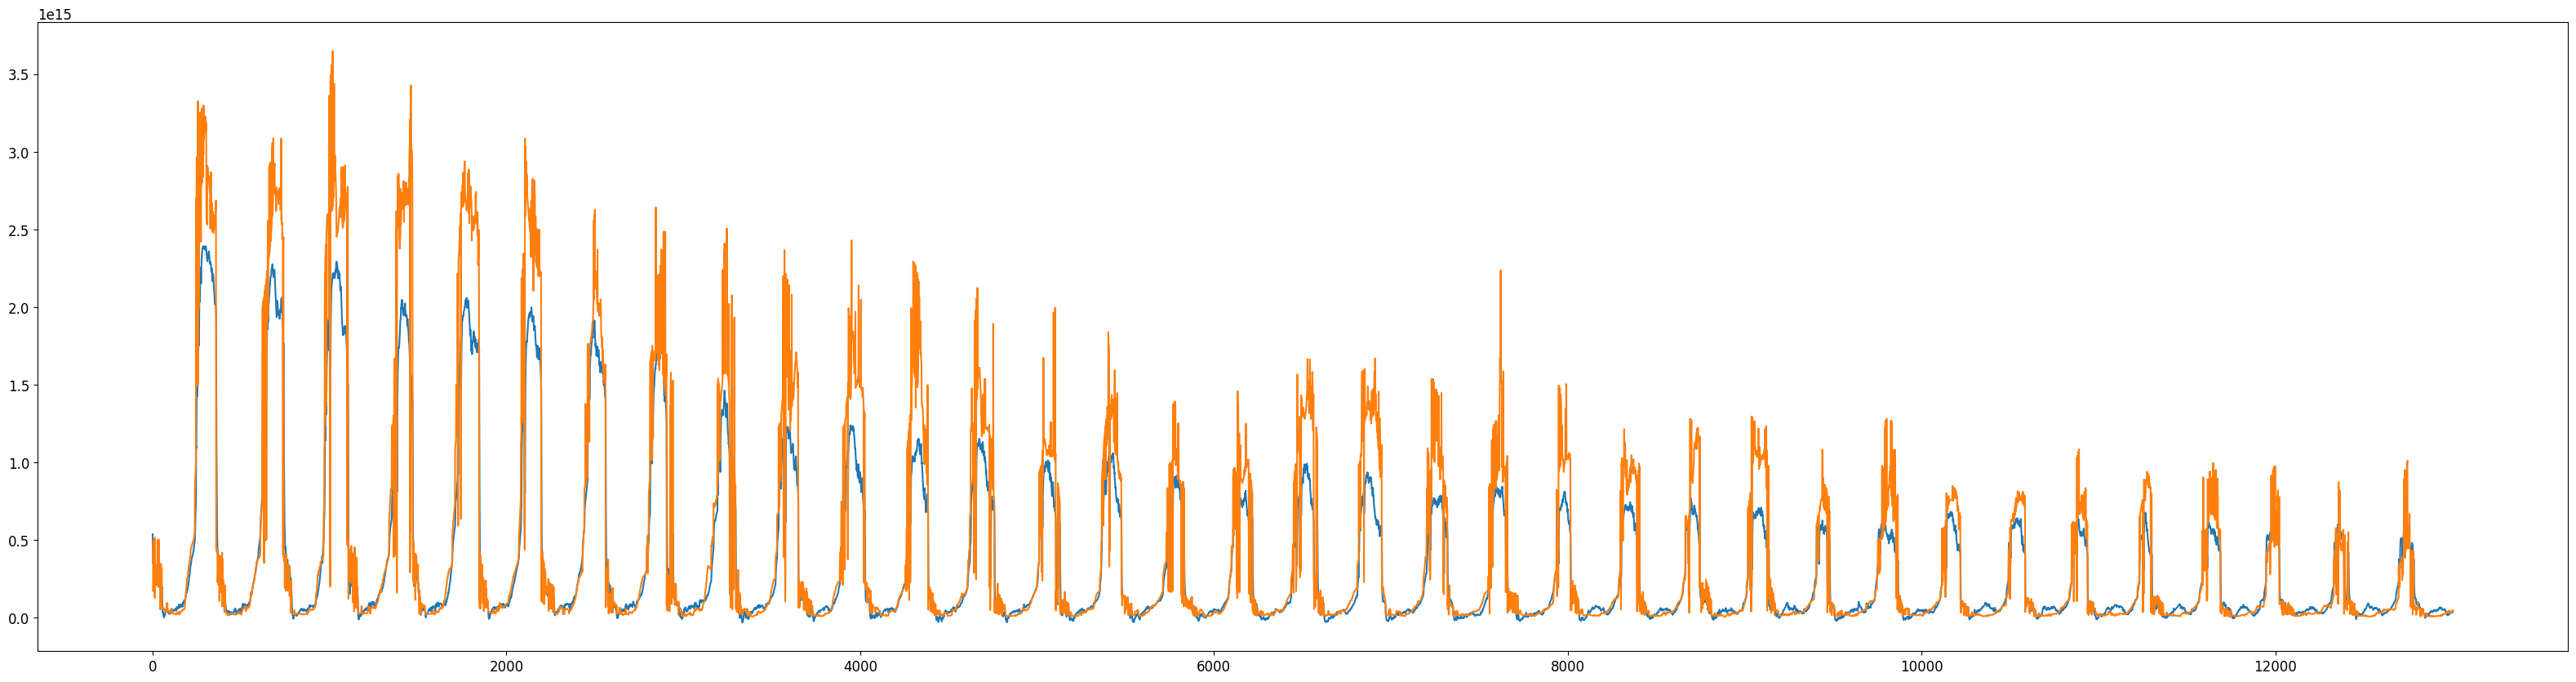

In [31]:
plt.figure(figsize=(40,10))
p = scaler.inverse_transform(PGRNNe.reshape(-1, 1)).T[0]
plt.plot(range(len(p)),p)
plt.plot(range(len(p)),HybridDF['PEPItrue'][100:])

In [33]:
PGRNNe =H0.predict(X)
v =  scaler.inverse_transform(PGRNNe.reshape(-1, 1)).T[0]
PGRNNdf = pd.DataFrame().assign(PGRNNe = v,
                                Time = Hyb.iloc[100:-1,:].Time.values)
# PGRNNdf.to_csv('PGRNNdf1.csv')

407/407 [==============================] - 3s 9ms/step


NameError: name 'plgm' is not defined

#### Sensitivity analysis

In [32]:
feature_importances = np.zeros(X.shape[2])
clear_output()
best_weights = [1]
best_models = [H0]

baseline_score = 0
for i, model in enumerate(best_models):
    pred = model.predict(X)
    pred += abs(np.min(pred))
    score = np.array(rmse(y,pred))
    baseline_score += score * best_weights[i]
baseline_score /= np.sum(best_weights)
for i in range(X.shape[2]):
    X_test = np.copy(X)
    X_test[:,:,i] = 0
    score = 0
    for j, model in enumerate(best_models):
        pred = model.predict(X_test)
        pred += abs(np.min(pred))
        score +=  rmse(y,pred) * best_weights[j]
    feature_importances[i] = np.abs(baseline_score - score)
    
    
names = list(HybridDF.columns)[:-1]
sorted_indices = np.argsort(feature_importances)[::-1]
for i in range(len(sorted_indices)):
    print(f"{i+1}. {names[sorted_indices[i]]} : {feature_importances[sorted_indices[i]]}")

407/407 [==============================] - 3s 7ms/step
1. EpiPpred : 0.07617001980543137
2. HypPpred : 0.03691074252128601
3. EpiV : 0.015766054391860962
4. HypV : 0.007439859211444855
5. EpiTemp : 0.004288777709007263
6. HypTemp : 0.003876984119415283
7. St : 0.0031880661845207214
8. u2*[m/s] : 0.0024151206016540527
9. sol[W/m2] : 0.0005289316177368164
10. PLoad : 4.6558678150177e-05


#### -----

In [27]:
def get_input_gradients(model, x):
    # Convert the input to a tensor
    x = np.reshape(x, (x.shape[0], 100, 11))
    x_tensor = tf.convert_to_tensor(x)
    
    # Compute the gradients of the output with respect to the input
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        output = model(x_tensor)
        
    gradients = tape.gradient(output, x_tensor)
    
    # Convert the gradients to a numpy array
    gradients = tf.keras.backend.get_value(gradients)
    
    # Compute the absolute sum of the gradients for each feature
    feature_importances = np.sum(np.abs(gradients), axis=0)
    
    return feature_importances

# Compute the feature importances for a sample input
x_sample = X_train[0:1, :, :]
feature_importances = get_input_gradients(model1, x_sample)

# Print the feature importances
#print("Feature importances:", feature_importances)

# Compute the average feature importances across all timesteps
average_importances = np.mean(feature_importances, axis=0)

# Rank the features based on their importance
sorted_indices = np.argsort(average_importances)[::-1]

# Print the feature rankings
print("Feature rankings:")
names = list(HybridDF.columns)[:-1]
for i in range(len(sorted_indices)):
    print(f"{i+1}. {names[sorted_indices[i]]}")#: {average_importances[sorted_indices[i]]}")


Feature rankings:
1. EpiV
2. u2*[m/s]
3. EntrTP
4. HypV
5. Qout[m3/d]
6. sol[W/m2]
7. EpiTemp
8. Hvd
9. HypTemp
10. St
11. PLoad[g]


In [ ]:
weights_range = np.arange(0.05, 1, 0.18)
y_true = y_test
def concatenate_data(X_train, y_train, X_test, y_test):
    X = np.concatenate([X_train, X_test], axis=0)
    y = np.concatenate([y_train, y_test], axis=0)
    return X, y
def Unreshape_df(Xs, ys=None):
    X = np.concatenate(Xs, axis=0)
    if ys is not None:
        y = np.concatenate(ys, axis=0)
        return X, y
    else:
        return X

def rmse(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true)))  
def calculate_weighted_average(predictions, weights):
    return sum([weight*preds for preds, weight in zip(predictions, weights)])

def evaluate_ensemble(predictions, weights, y_true):
    pred = calculate_weighted_average(predictions, weights)
    loss = rmse(y_true,pred)
    return r2_score(y_true, pred),loss

#def Ensemble_weights(weights_range,y_true):
best_models = [model1,model2,model3,model4,model5,model6]
predictions = []
losses = []
for model in best_models:
    y_pred = model.predict(X_test)
    loss = rmse(y_true,y_pred)
    losses.append(loss)
    predictions.append(y_pred)
iterations = len(weights_range) ** len(best_models)
best_weights = None
best_score = None
best_loss = None
track= {}
si = 0
bi = 0
#found = lambda si,bi,best_score: (si> 0 and bi> 0 and si > bi*100000) or (best_score is not None and best_score > 0.91)
found = lambda si,bi,best_score: si> 0 and bi> 0 and si > bi*10000 or best_score is not None and best_score > 0.91
for wx0, w1 in enumerate(weights_range):
    if found(si,bi,best_score):
        wx0 = weights_range[len(weights_range)-1]
        break
    for wx1, w2 in enumerate(weights_range):
        if found(si,bi,best_score):
            wx1 = weights_range[len(weights_range)-1]
            break
        for wx2, w3 in enumerate(weights_range):
            if found(si,bi,best_score):
                wx2 = weights_range[len(weights_range)-1]
                break
            for wx3, w4 in enumerate(weights_range):
                if found(si,bi,best_score):
                    wx3 = weights_range[len(weights_range)-1]
                    break
                for wx5, w5 in enumerate(weights_range):
                    if found(si,bi,best_score):
                        wx5 = weights_range[len(weights_range)-1]
                        break
                    for wx6, w6 in enumerate(weights_range):
                        if found(si,bi,best_score):
                            wx6 = weights_range[len(weights_range)-1]
                            clear_output(wait = True)
                            print(f'{best_score:.2%}')
                            print(f'{found(si,bi,best_score)}')
                            print(f'{si},{bi}')
                            break
                        else:
                            w = [random.choice(weights_range) for _ in range(6)]
                            weights = [nu/sum(w) for nu in w]
                            score = evaluate_ensemble(predictions, weights, y_true)[0]
                            s_loss = evaluate_ensemble(predictions, weights, y_true)[1]
                            si += 1
                            if best_score is None or np.round(score,2) >= np.round(best_score,2):
                                clear_output(wait = True)
                                cond = (best_score is None or best_loss is None) or (np.round(score,4) > np.round(best_score,4) and np.round(s_loss, 2) <= np.round(best_loss,2))
                                if cond:
                                    bi += 1
                                    best_score = score 
                                    best_loss = s_loss
                                    best_weights = weights
                                    track[bi] = {'Titer':si,'score':best_score , 'loss':best_loss}
                                    if (np.round(s_loss,2) < np.round(best_loss, 2)):
                                        if not cond:
                                            bi += 1
                                        best_score = score 
                                        best_loss = s_loss
                                        best_weights = weights        
                                        track[bi] = {'Titer':si,'score':best_score , 'loss':best_loss}


                                print(f'{best_loss}')
                                print(f'{best_score:.2%}')
                                print(f'{best_weights}')
                                print(f'{found(si,bi,best_score)}')
                                print(f'recent')

                            if si> 0 and bi> 0:
                                clear_output(wait = True)
                                print(f'{score:.2%}')
                                print(f'{loss}')
                                print(f'{weights}')
                                print(f'{found(si,bi,best_score)}')
                                print(f'{si},{bi}')
                                print(f'#### Best ####')
                                print(f'{best_score:.2%}')
                                print(f'{best_loss}')
                                print(f'{best_weights}')
                                
                            if found(si,bi,best_score):
                                wx6 = weights_range[len(weights_range)-1]
                                break
                        if found(si,bi,best_score):
                            break
                    if found(si,bi,best_score):
                        break
                if found(si,bi,best_score):
                    break
            if found(si,bi,best_score):
                break
        if found(si,bi,best_score):
            break
    if found(si,bi,best_score):
        track[bi] = {'Titer':si,'score':best_score , 'loss':best_loss}
        print(best_weights, best_score)
        #return(track,best_weights,best_score)

83.44%
0.11919166147708893
[0.10087719298245613, 0.4166666666666667, 0.02192982456140351, 0.17982456140350878, 0.2587719298245615, 0.02192982456140351]
False
46297,6
#### Best ####
84.22%
0.11556944251060486
[0.017730496453900707, 0.017730496453900707, 0.017730496453900707, 0.2730496453900709, 0.3368794326241134, 0.3368794326241134]


In [14]:
### best_weights = [0.03623188405797102, 0.03623188405797102, 0.03623188405797102, 0.16666666666666666, 0.03623188405797102, 0.6884057971014493]
def Ensemble(X_topredict,best_weights):    
    model_predictions = []
    # Generate predictions from each individual model in the ensemble
    best_models = [model1,model2,model3,model4,model5,model6]
    model_predictions = []
    for model in best_models:
        y_pred = model.predict(X_topredict)
        model_predictions.append(y_pred)
    final_prediction = calculate_weighted_average(model_predictions, best_weights)
    return final_prediction
#pred = Ensemble(X,best_weights)

In [56]:
def get_input_gradients(ensemble_models, ensemble_weights, x):
    # Convert the input to a tensor
    x = np.reshape(x, (x.shape[0], 100, 11))
    x_tensor = tf.convert_to_tensor(x)
    
    # Compute the gradients of the output with respect to the input for each model in the ensemble
    gradients = []
    for i, model in enumerate(ensemble_models):
        with tf.GradientTape() as tape:
            tape.watch(x_tensor)
            output = model(x_tensor)
        gradient = tape.gradient(output, x_tensor)
        gradients.append(gradient * ensemble_weights[i])
    
    # Convert the gradients to a numpy array
    gradients = tf.keras.backend.batch_get_value(gradients)
    
    # Compute the absolute sum of the gradients for each feature across all models in the ensemble
    feature_importances = np.sum(np.abs(gradients), axis=(0, 1))
    
    return feature_importances

x_sample = X_train[0:1, :, :]
feature_importances = get_input_gradients(ensemble_models = best_models, ensemble_weights = best_weights, x = x_sample)

# Compute the average feature importances across all timesteps
ai = np.mean(feature_importances, axis=0)
average_importances = np.round(ai/np.sum(ai),2)

# Rank the features based on their importance
sorted_indices = np.argsort(average_importances)[::-1]

# Print the feature rankings
print("Feature rankings:")
names = list(HybridDF.columns)[:-1]
for i in range(len(sorted_indices)):
    print(f"{i+1}. {names[sorted_indices[i]]} : {average_importances[sorted_indices[i]]}")

Feature rankings:
1. EpiV : 0.39
2. MMphyp : 0.1
3. PLoad[g] : 0.1
4. HypV : 0.09
5. u2*[m/s] : 0.08
6. sol[W/m2] : 0.07
7. MMpepi : 0.05
8. Qout[m3/d] : 0.05
9. EpiTemp : 0.04
10. HypTemp : 0.03
11. St : 0.02


In [78]:
baseline_score = 0
for i, model in enumerate(best_models):
    pred = model.predict(X)
    score = rmse(y,pred)#.numpy()
    baseline_score += score * best_weights[i]
baseline_score /= np.sum(best_weights)

feature_importances = np.zeros(X.shape[2])
clear_output()
for i in range(X.shape[2]):
    X_test = np.copy(X)
    X_test[:,:,i] = 0
    score = 0
    for j, model in enumerate(best_models):
        pred = model.predict(X_test)
        score +=  rmse(y,pred) * best_weights[j]
    feature_importances[i] = np.abs(baseline_score - score)

407/407 [==============================] - 19s 46ms/step


In [82]:
sorted_indices = np.argsort(feature_importances)[::-1]
for i in range(len(sorted_indices)):
    print(f"{i+1}. {names[sorted_indices[i]]} : {feature_importances[sorted_indices[i]]}")

1. EpiV : 0.16828951643819498
2. HypV : 0.036635134633339866
3. sol[W/m2] : 0.009686547734424539
4. MMpepi : 0.006748639337771312
5. EpiTemp : 0.002623063875428308
6. MMphyp : 0.0022649476502803745
7. HypTemp : 0.0022082301319068104
8. u2*[m/s] : 0.0006353072557888917
9. St : 0.0006282439997009892
10. Qout[m3/d] : 0.00029930321777123237
11. PLoad[g] : 2.6732260452466683e-07


In [16]:
def calculate_weighted_average(predictions, weights):
    return sum([weight*preds for preds, weight in zip(predictions, weights)])

In [18]:
import pickle

In [40]:
pred = scaler.inverse_transform(Ensemble(X,best_weights).reshape(-1, 1)).T[0]
with open('HYB0pred.pkl', 'wb') as f:
    pickle.dump(pred, f)

407/407 [==============================] - 21s 51ms/step


In [43]:
pred.shape

(13006,)

In [ ]:
plt.plot(np.flip(pred[:360]))

In [31]:
r2_score(y_true, pred),rmse(y_true,pred)

(0.842155553027361, 0.11556944)

In [ ]:
scaler.inverse_transform(pred.T)[0]

### Hybrid model

In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
import tensorflow_probability as tfp
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from keras import backend as K
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())
def Ldeltas(y_true, y_pred):
    y_true_diffs = tf.experimental.numpy.abs(tf.experimental.numpy.diff(y_true, axis=0))
    p_80 = tfp.stats.percentile(y_true_diffs, 80)
    y_pred_diffs = tf.experimental.numpy.abs(tf.experimental.numpy.diff(y_pred, axis=0))
    delta = tf.reduce_sum(tf.nn.relu(y_pred_diffs - p_80))
    return delta / tf.cast(tf.shape(y_true)[0], tf.keras.backend.floatx())
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

def Lstft(y_true, y_pred):
    s_pred = tf.abs(tf.signal.rfft(y_pred))
    s_true = tf.abs(tf.signal.rfft(y_true))
    stft = tf.reduce_sum(tf.abs(s_pred - s_true))
    return stft / (tf.cast(tf.shape(y_true)[0], tf.keras.backend.floatx()) // 2 + 1)

def combined_loss(y_true, y_pred):
#def combined_loss(y_true, y_pred,lambda1,lambda2):
    rmse = K.sqrt(K.mean(K.square(y_pred - y_true)))
    ldeltas = Ldeltas(y_true, y_pred)
    lstft = Lstft(y_true, y_pred)
    lambda1 = 0.5 # choose a value for lambda1
    lambda2 = 0.5 # choose a value for lambda2
    return rmse + lambda1 * ldeltas + lambda2 * lstft

In [ ]:
from skopt.callbacks import DeltaYStopper
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True)

# Define the search space
search_space = [Categorical([40,80,160], name='batch_size'),
                Categorical([20,50,100], name='epochs'),
                Real(1e-6, 1e-4, name='learning_rate'),
                Categorical(['relu', 'tanh','selu','elu'], name='activation'),
                Real(0.0, 0.5, name='dropout_rate'),
                Categorical(['adam', 'rmsprop','Adamax'], name='optimizer'),
                Integer(50, 200, name='num_units'),
                Integer(1, 3, name='num_layers'),
                Real(0.1,0.9,name='lambda1'), 
                Real(0.1,0.9,name='lambda2')]

@use_named_args(search_space)
def objective(**params):
    # Unpack the hyperparameters
    batch_size = params['batch_size']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    activation = params['activation']
    dropout_rate = params['dropout_rate']
    optimizer = params['optimizer']
    num_units = params['num_units']
    num_layers = params['num_layers']
    l1 = params['lambda1']
    l2 = params['lambda2']
    
    # Create and compile a model with the current combination of hyperparameters
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    Hybrid = Sequential()
    Hybrid.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='input_layer'))
    
    for i in range(num_layers):
        if i == num_layers - 1:
            Hybrid.add(GRU(units=num_units,
                           activation=activation,
                           dropout=dropout_rate,
                           return_sequences=False,
                           name=f'Hidden_layer_{i+1}'))
        else:
            # Not the last GRU layer
            Hybrid.add(GRU(units=num_units,
                           activation=activation,
                           dropout=dropout_rate,
                           return_sequences=True,
                           name=f'Hidden_layer_{i+1}'))
    Hybrid.add(Dense(1))
    Hybrid.compile(loss=combined_loss(l1,l2), optimizer=opt, metrics=[r_squared])
    
    # Train the model on the training data for this fold
    history = Hybrid.fit(X_train_kfold, y_train_kfold,
                           batch_size=batch_size,
                           epochs=epochs)
    
    # Evaluate the model on the validation data for this fold
    val_loss, val_r_squared = Hybrid.evaluate(X_val_kfold, y_val_kfold)
    
    return val_loss

delta_stopper = DeltaYStopper(delta=0.1)
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5, mode ='min',verbose =0) 
for train_index, val_index in kfold.split(X_train, y_train):
    X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
    y_train_kfold, y_val_kfold = y_train[train_index], y_train[val_index]
    
    # Perform Bayesian optimization on the training data for this fold
    res_gp = gp_minimize(objective,
                         search_space,
                         n_calls=30,
                         random_state=0,
                        callback=[delta_stopper])
    
    # Print the best score and best parameters for this fold
    print(f"Best score for fold {i}: {res_gp.fun} using {res_gp.x}")

###

Yes, the code I provided performs a hyperparameter search for each fold of the k-fold cross-validation to find the best GRU architecture and hyperparameters for each fold. The training data is split into k folds in a way that preserves the temporal order of the data (if shuffle=False) or ensures that each fold has a similar proportion of samples from each class (if shuffle=True and y_train is provided as the second argument to kfold.split). This helps to avoid bias towards a specific part of your data. The hyperparameter search is performed on the training data for each fold and the best combination of hyperparameters is selected based on its performance on the validation data for that fold. This process is repeated k times, with each fold serving as the validation set once. The average performance of the best models across the k folds can then be used as an estimate of the performance of your model on unseen data.


by performing k-fold cross-validation with hyperparameter search, you can find the best architecture and hyperparameters for your GRU model while avoiding bias towards a specific part of your data. The k-fold cross-validation splits your training data into k folds in a way that preserves the temporal order of the data (if shuffle=False) or ensures that each fold has a similar proportion of samples from each class (if shuffle=True and y_train is provided as the second argument to kfold.split). This helps to avoid bias towards a specific part of your data. The hyperparameter search is performed on the training data for each fold and the best combination of hyperparameters is selected based on its performance on the validation data for that fold. This process is repeated k times, with each fold serving as the validation set once. The average performance of the best models across the k folds can then be used as an estimate of the performance of your model on unseen data.

After performing the k-fold cross-validation with hyperparameter search, you can retrieve the best combination of hyperparameters and use it to train a final model on your entire training dataset. This final model can then be used to make predictions on new data.

In [ ]:
# Create and compile a model with the best combination of hyperparameters
opt = keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
GRUmodel = Sequential()
GRUmodel.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='input_layer'))
for i in range(best_params['num_layers']):
    GRUmodel.add(GRU(units=best_params['num_units'], activation=best_params['activation'], dropout=best_params['dropout_rate'], name=f'Hidden_layer_{i+1}'))
GRUmodel.add(Dense(1))
GRUmodel.compile(loss=rmse, optimizer=opt, metrics=[r_squared])

# Train the model on the entire training dataset
history = GRUmodel.fit(X_train, y_train,
                       batch_size=best_params['batch_size'],
                       epochs=best_params['epochs'])

# Use the trained model to make predictions on new data
y_pred = GRUmodel.predict(X_test)

In [ ]:
pred = model.predict(X_test)
r2_score(y_test,pred),rmse(y_test,pred)

In [ ]:
plt.plot(np.flip(pred[:365]))

In [ ]:
scaler.inverse_transform(unpred.reshape(-1, 1)).T

In [ ]:
unpred = Unreshape_df(Xs = pred)
predicted = scaler.inverse_transform(unpred.reshape(-1, 1)).T[0]
observed =  scaler.inverse_transform(Unreshape_df(Xs = y_test).reshape(-1, 1)).T[0]
r2_score(predicted,observed)